# OpenDrift simulations forced by a regional ocean model (NEMO)

***

In [2]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import ticker
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cmocean import cm
from datetime import datetime, timedelta
from dateutil.parser import parse
from IPython.display import HTML
from opendrift.readers import reader_netCDF_CF_unstructured
from opendrift.models.oceandrift import OceanDrift

plt.rcParams['animation.html'] = 'html5'
plt.rcParams['font.size'] = 12

***

## Define paths

Remote path from SSC-NEMO erddap server

In [3]:
# Define paths, grid, and mask
paths = {
    'erddap': 'https://salishsea.eos.ubc.ca/erddap/griddap',
    'local': '/data/bmoorema/results/opendrift',
}
grid = xr.open_dataset(os.path.join(paths['erddap'], 'ubcSSnBathymetryV17-02'))
mask = xr.open_dataset(os.path.join(paths['erddap'], 'ubcSSn3DMeshMaskV17-02'))

***

## Hydrodynamic forcing: SalishSeaCast (NEMO)

In [4]:
def plot_SSC_domain():
    """Plot the SalishSeaCast domain
    """

    # Draw map
    xlim, ylim = [-126.5, -121.2], [46.8, 51.2]
    fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    ax.set_extent(xlim + ylim)
    ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood'))

    # Overlay model domain and bathymetry
    c = ax.contourf(
        grid.longitude, grid.latitude, grid.bathymetry, levels=np.arange(0, 451, 50),
        cmap=cm.deep, extend='both', transform=crs.PlateCarree(), zorder=2,
    )
    for attr, color in zip(['contourf', 'contour'], ['lightgray', 'k']):
        getattr(ax, attr)(
            grid.longitude, grid.latitude, mask.tmask[0, 0, ...],
            levels=[-0.01, 0.01], colors=color, transform=crs.PlateCarree(), zorder=2,
        )
    lons, lats, corners = [], [], [(0, 0), (0, -1), (-1, -1), (-1, 0), (0, 0)]
    for i in corners: lons.append(grid.longitude[i]), lats.append(grid.latitude[i])
    ax.plot(lons, lats, 'k-', transform=crs.PlateCarree(), zorder=2)

    # Overlay gridlines and add colorbar
    xlocs, ylocs = [ticker.FixedLocator(np.arange(np.floor(l[0]), np.ceil(l[1])+1)) for l in [xlim, ylim]]
    gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs)
    gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    gl.xlabels_top, gl.ylabels_right = False, False
    fig.colorbar(c, cax=cax, label='Depth [m]')
    fig.savefig('/home/bmoorema/Desktop/domain.pdf', bbox_inches='tight')

### Model domain and description

SalishSeaCast is a regional NEMO configuration on the Canadian Pacific south coast near Vancouver. The model domain has been rotated approximately 29$^{\circ}$ CCW from north to minimize open boundaries and land points. The rotation was done using Matlab orthogonal curvilinear grid creator, [Seagrid](https://github.com/sea-mat/seagrid), and thus has no formal `proj4` definition for the relation between lon/lat and x/y. I'm currently using `opendrift.readers.reader_netCDF_CF_unstructured` to load the NEMO results as a reader object, and could not find a better alternative.

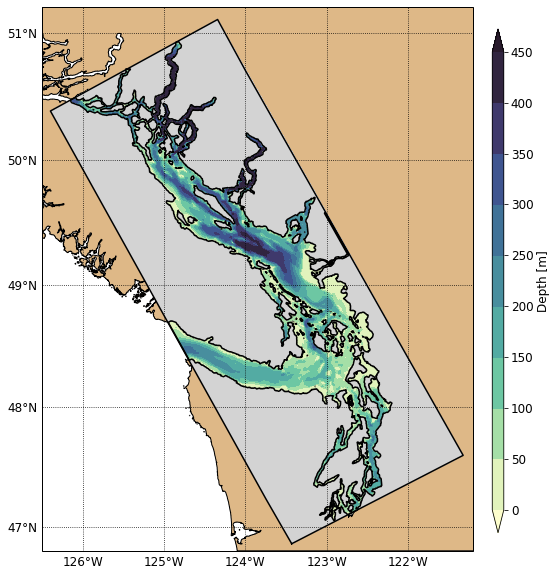

In [5]:
# Plot SSC domain
plot_SSC_domain()

***

## Local functions
For transforming water velocities from the model U and V grid points to lon/lat. (More sophisticated versions exist, these are used here for simplicity)

In [4]:
def unstagger(u, v):
    """Unstagger velocities from u,v points to t points
    """
    
    u = np.add(u[..., :-1], u[..., 1:]) / 2
    v = np.add(v[..., :-1, :], v[..., 1:, :]) / 2
    
    return u[..., 1:, :], v[..., 1:]

In [5]:
def rotate(u, v):
    """Rotate velocities from model grid to lon/lat space (29 deg)
    """

    theta = 29 * np.pi / 180
    u = u * np.cos(theta) - v * np.sin(theta)
    v = u * np.sin(theta) + v * np.cos(theta)

    return u, v

***

## Pre-process forcing files
Specify date range

In [6]:
# Daterange for simulation
daterange = [parse(d) for d in ['2017 Nov 10 00:00', '2017 Nov 20 00:00']]

# Forcing path
fn = 'SalishSea_1h_' + '_'.join(d.strftime('%Y%m%d') for d in daterange) + '_opendrift.nc'
forcing_NEMO = os.path.join(paths['local'], 'forcing', fn)

Load and process SSC NEMO results from erddap

In [9]:
# Load forcing data from ERDDAP
raw = []
for vel in ['u', 'v']:
    with xr.open_dataset(os.path.join(paths['erddap'], f'ubcSSg3D{vel}GridFields1hV18-06')) as data:
        time = data.time.sel(time=slice(*daterange))
        raw.append(data[f'{vel}Velocity'].sel(time=slice(*daterange))[:, 0, ...].values)

# Unstagger velocities to T points and rotate to lon/lat
u, v = rotate(*unstagger(*raw))

# Reshape, remove landpoints, and save to local netCDF path
tmask = mask.tmask[0, 0, 1:, 1:].values.reshape(-1).astype(bool)
ds = xr.Dataset(
    {
        'longitude': ('flat', grid.longitude[1:, 1:].values.reshape(-1)[tmask]),
        'latitude': ('flat', grid.latitude[1:, 1:].values.reshape(-1)[tmask]),
        'u': (['time', 'flat'], u.reshape(time.size, -1)[:, tmask], {'standard_name': 'x_sea_water_velocity'}),
        'v': (['time', 'flat'], v.reshape(time.size, -1)[:, tmask], {'standard_name': 'y_sea_water_velocity'}),
    },
    coords={'time': time}
).to_netcdf(forcing_NEMO)

***

## OpenDrift simulation
   * OceanDrift model
   * Unstructured netCDF reader
   * Basemap coastline
   * No wind forcing
   * 1 hour timestep
   * 4th order Runge-Kutta

In [7]:
# OpenDrift run configuration and parameters
o = OceanDrift(loglevel=20)
o.set_config('general:coastline_action', 'previous')
o.set_config('drift:scheme', 'runge-kutta4')
o.add_reader(reader_netCDF_CF_unstructured.Reader(forcing_NEMO))
o.seed_elements(-123.2, 49.0, radius=1000, time=daterange[0], number=500)

10:17:06 INFO: OpenDriftSimulation initialised (version 1.0.6)
10:17:06 INFO: Opening dataset: /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc
10:17:06 INFO: Opening file with Dataset


In [8]:
%%capture
# Run simulation
o.run(outfile='/data/bmoorema/results/opendrift/results/test.nc')

10:17:28 INFO: Config validation OK
10:17:28 INFO: Fallback values will be used for the following variables which have no readers: 
10:17:28 INFO: 	x_wind: 0.000000
10:17:28 INFO: 	y_wind: 0.000000
10:17:28 INFO: Duration, steps or end time not specified, running until end of first reader: 2017-11-19 23:30:00
10:17:28 INFO: Adding a dynamical landmask (resolution "h") based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
10:17:28 INFO: No display found. Using non-interactive Agg backend
10:17:41 INFO: Using existing reader for land_binary_mask
10:17:41 INFO: All points are in ocean
10:17:41 INFO: 2017-11-10 00:00:00 - step 1 of 239 - 500 active elements (0 deactivated)
10:17:57 INFO: 2017-11-10 01:00:00 - step 2 of 239 - 500 active elements (0 deactivated)
10:18:05 INFO: 2017-11-10 02:00:00 - step 3 of 239 - 500 active elements (0 deactivated)
10:18:12 INFO: 2017-11-10 03:00:00 - step 4 of 239 - 500 active elements (0 deactivated)
10:18:20 INFO: 2017-11

10:29:15 INFO: 2017-11-13 13:00:00 - step 86 of 239 - 500 active elements (0 deactivated)
10:29:23 INFO: 2017-11-13 14:00:00 - step 87 of 239 - 500 active elements (0 deactivated)
10:29:31 INFO: 2017-11-13 15:00:00 - step 88 of 239 - 500 active elements (0 deactivated)
10:29:39 INFO: 2017-11-13 16:00:00 - step 89 of 239 - 500 active elements (0 deactivated)
10:29:47 INFO: 2017-11-13 17:00:00 - step 90 of 239 - 500 active elements (0 deactivated)
10:29:55 INFO: 2017-11-13 18:00:00 - step 91 of 239 - 500 active elements (0 deactivated)
10:30:03 INFO: 2017-11-13 19:00:00 - step 92 of 239 - 500 active elements (0 deactivated)
10:30:11 INFO: 2017-11-13 20:00:00 - step 93 of 239 - 500 active elements (0 deactivated)
10:30:20 INFO: 2017-11-13 21:00:00 - step 94 of 239 - 500 active elements (0 deactivated)
10:30:28 INFO: 2017-11-13 22:00:00 - step 95 of 239 - 500 active elements (0 deactivated)
10:30:36 INFO: 2017-11-13 23:00:00 - step 96 of 239 - 500 active elements (0 deactivated)
10:30:44 I

10:41:30 INFO: 2017-11-17 07:00:00 - step 176 of 239 - 500 active elements (0 deactivated)
10:41:38 INFO: 2017-11-17 08:00:00 - step 177 of 239 - 500 active elements (0 deactivated)
10:41:47 INFO: 2017-11-17 09:00:00 - step 178 of 239 - 500 active elements (0 deactivated)
10:41:55 INFO: 2017-11-17 10:00:00 - step 179 of 239 - 500 active elements (0 deactivated)
10:42:03 INFO: 2017-11-17 11:00:00 - step 180 of 239 - 500 active elements (0 deactivated)
10:42:11 INFO: 2017-11-17 12:00:00 - step 181 of 239 - 500 active elements (0 deactivated)
10:42:20 INFO: 2017-11-17 13:00:00 - step 182 of 239 - 500 active elements (0 deactivated)
10:42:29 INFO: 2017-11-17 14:00:00 - step 183 of 239 - 500 active elements (0 deactivated)
10:42:37 INFO: 2017-11-17 15:00:00 - step 184 of 239 - 500 active elements (0 deactivated)
10:42:46 INFO: 2017-11-17 16:00:00 - step 185 of 239 - 500 active elements (0 deactivated)
10:42:54 INFO: 2017-11-17 17:00:00 - step 186 of 239 - 500 active elements (0 deactivated)

In [9]:
%%capture
# Make animation
anim = o.animation()

In [10]:
# Display animation
HTML(anim.to_html5_video())

11:30:07 INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
11:30:07 INFO: figure size (inches) has been adjusted from 9.99810558584112 x 10.0 to 9.972222222222221 x 10.0
11:30:07 INFO: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '718x720', '-pix_fmt', 'rgba', '-r', '20.0', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp8fz8qpgu/temp.m4v']


***

## Analysis

In [41]:
def plot_vel(xlim, ylim):
    """Plot u and v velocities
    """
    
    fig, axs = plt.subplots(2, 1, figsize=(17, 6))
    for ax in axs: ax.plot(xlim, [0, 0], 'k--', zorder=1), ax.set_xlim(xlim), ax.set_ylim(ylim)
    for u, v in zip(ds.x_sea_water_velocity, ds.y_sea_water_velocity):
        for ax, vel in zip(axs, [u, v]): ax.plot(ds.time, vel, zorder=0)
    
    return fig, axs

Load simulation results and define zoom region

In [42]:
# Load simulation results
ds = xr.open_dataset('/data/bmoorema/results/opendrift/results/test.nc')
datezoom = [parse(d) for d in ('2017 Nov 11 10:00', '2017 Nov 15 00:00')]
ylim = [-1, 1]

Plot $u$ and $v$ velocities for whole simulation

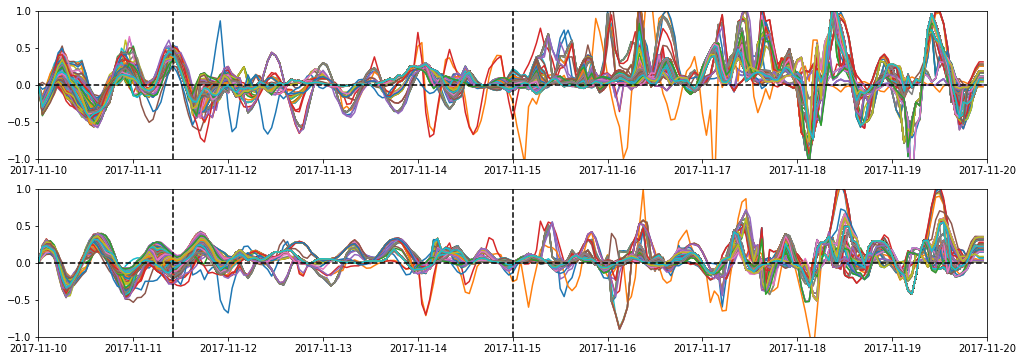

In [43]:
# Plot u and v for whole simulation
fig, axs = plot_vel(daterange, ylim)
for ax in axs:
    for d in datezoom: ax.plot([d, d], ylim, 'k--')

Plot $u$ and $v$ velocities for region where trajectories become unphysical

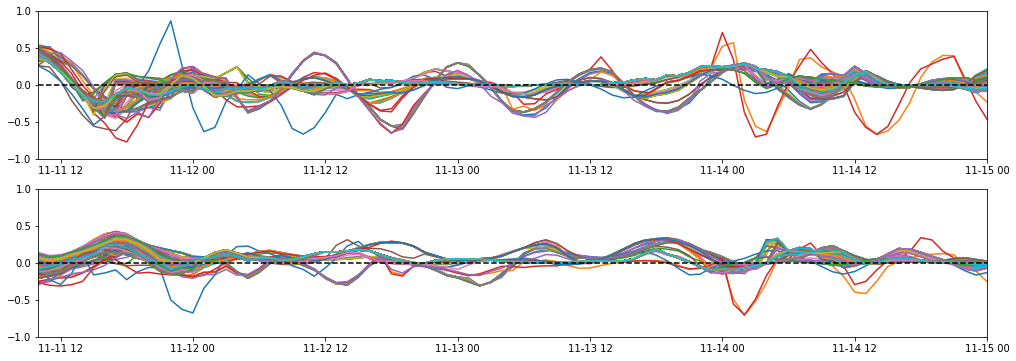

In [44]:
# Plot u and v for nonphysical time region
fig, axs = plot_vel(datezoom, ylim)

It looks like the velocities become unphysically small after a few days, especially given that the region has strong tides and wind, and a large river plume.